### Dataset Link: https://www.kaggle.com/competitions/ventilator-pressure-prediction/data
### Columns
- id - globally-unique time step identifier across an entire file
breath_id - globally-unique time step for breaths
- R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
- C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
- time_step - the actual time stamp.
- u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
- u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
- pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 198 kB 57.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=96259643baa5596e63b132f04c26d89727ff572c1fd9c9774706392a9bbd7bfe
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:

import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import col, count ,isnan , when ,datediff ,date_format , to_date , to_timestamp ,lit
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder , StringIndexer , VectorAssembler ,StandardScaler,Normalizer
from pyspark.ml.clustering import KMeans , KMeansModel
from pyspark.ml.evaluation import  ClusteringEvaluator

## **Load Data**

In [ ]:
spark=SparkSession.builder.appName("Clustering").getOrCreate()

In [ ]:
df=spark.read.csv("/content/drive/MyDrive/ventilator pressure.csv",header=True)

In [ ]:
df.show()

+---+---------+---+---+--------------------+-------------------+-----+------------------+
| id|breath_id|  R|  C|           time_step|               u_in|u_out|          pressure|
+---+---------+---+---+--------------------+-------------------+-----+------------------+
|  1|        1| 20| 50|                   0|0.08333400563464438|    0| 5.837491705069121|
|  2|        1| 20| 50|0.033652305603027344| 18.383041472634716|    0|5.9077938505203464|
|  3|        1| 20| 50| 0.06751441955566406| 22.509277769756217|    0| 7.876253923154396|
|  4|        1| 20| 50| 0.10154223442077637| 22.808822256996738|    0|11.742871922971284|
|  5|        1| 20| 50|  0.1357555389404297| 25.355850299494183|    0|12.234986941129785|
|  6|        1| 20| 50| 0.16969776153564453| 27.259865858889704|    0|12.867706250190738|
|  7|        1| 20| 50| 0.20370793342590332| 27.127485642715275|    0|14.695562031922366|
|  8|        1| 20| 50| 0.23772263526916504| 26.807731765059422|    0| 15.89069850459303|
|  9|     

## **Displaying the types of Dataframe columns**

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- breath_id: string (nullable = true)
 |-- R: string (nullable = true)
 |-- C: string (nullable = true)
 |-- time_step: string (nullable = true)
 |-- u_in: string (nullable = true)
 |-- u_out: string (nullable = true)
 |-- pressure: string (nullable = true)



## **Converting dataframe numerical columns to float data type instead of string**

In [ ]:
df=df.select(*(col(c).cast("float").alias(c) for c in df.columns))
df.printSchema()

root
 |-- id: float (nullable = true)
 |-- breath_id: float (nullable = true)
 |-- R: float (nullable = true)
 |-- C: float (nullable = true)
 |-- time_step: float (nullable = true)
 |-- u_in: float (nullable = true)
 |-- u_out: float (nullable = true)
 |-- pressure: float (nullable = true)



## **Checking for Nulls in each column of the dataframe**

In [ ]:
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+---+---------+---+---+---------+----+-----+--------+
| id|breath_id|  R|  C|time_step|u_in|u_out|pressure|
+---+---------+---+---+---------+----+-----+--------+
|  0|        0|  0|  0|        0|   0|    0|       0|
+---+---------+---+---+---------+----+-----+--------+



## **Checking if there are duplicate rows in the dataframe**

In [ ]:
print(df.count()-df.distinct().count())

0


## **Dropping unneeded columns**

In [ ]:
columns_to_drop=['id','R','C','time_step']
df=df.drop(*(columns_to_drop))

## **Grouping the dataframe by getting the mean for each breadth id , as we have many instances of the same person so we want to aggregate them to a single meaningful value**

In [ ]:
pivotDF=df.groupby('breath_id').mean()
pivotDF.show()

+---------+--------------+------------------+----------+------------------+
|breath_id|avg(breath_id)|         avg(u_in)|avg(u_out)|     avg(pressure)|
+---------+--------------+------------------+----------+------------------+
|   2077.0|        2077.0| 4.710675767809152|    0.6375| 7.863951051235199|
|   8195.0|        8195.0|11.708975955843925|    0.6375| 9.515172666311264|
|   8559.0|        8559.0| 7.218330932408572|    0.6375|10.893094784021377|
|  33799.0|       33799.0| 5.898460828512907|     0.625| 9.049421006441117|
|    714.0|         714.0|  9.04502526000142|    0.6125| 14.54704881310463|
|   2098.0|        2098.0| 9.937471459060907|    0.6375|  9.12323824763298|
|   2318.0|        2318.0| 7.083714461186901|    0.6125|14.228931486606598|
|   2679.0|        2679.0| 6.629322958551347|     0.625|15.309827148914337|
|   3675.0|        3675.0| 5.338797570252791|     0.625|12.598800638318062|
|   4618.0|        4618.0| 4.790234274230897|    0.6375|11.677842432260514|
|   5039.0| 

In [ ]:
pivotDF.count()

75450

## **Removing the breath_id and its average after grouping**

In [ ]:
columns_to_drop=['breath_id','avg(breath_id)']
updated_df=pivotDF.drop(*(columns_to_drop))

In [ ]:
updated_df.show()

+------------------+----------+------------------+
|         avg(u_in)|avg(u_out)|     avg(pressure)|
+------------------+----------+------------------+
| 4.710675767809152|    0.6375| 7.863951051235199|
|11.708975955843925|    0.6375| 9.515172666311264|
| 7.218330932408572|    0.6375|10.893094784021377|
| 5.898460828512907|     0.625| 9.049421006441117|
|  9.04502526000142|    0.6125| 14.54704881310463|
| 9.937471459060907|    0.6375|  9.12323824763298|
| 7.083714461186901|    0.6125|14.228931486606598|
| 6.629322958551347|     0.625|15.309827148914337|
| 5.338797570252791|     0.625|12.598800638318062|
| 4.790234274230897|    0.6375|11.677842432260514|
|2.5827429996803404|    0.6125| 8.415822899341583|
| 5.232954978197813|     0.625|12.675254148244857|
| 5.998594860662706|     0.625|11.221757358312606|
|12.076128505170345|    0.6125|13.317640000581742|
| 4.568029441684485|    0.6125| 10.35352582335472|
| 3.254959386587143|       0.6|11.900173002481461|
| 24.89972441494465|    0.6125|

## **Vector Assembler**

In [ ]:
assembler = VectorAssembler(
    inputCols=updated_df.columns,
    outputCol="features"
)

In [ ]:
pipeline = Pipeline(stages=[assembler])
final_features=pipeline.fit(updated_df).transform(updated_df)
final_features.show(truncate=False)

+------------------+----------+------------------+----------------------------------------------+
|avg(u_in)         |avg(u_out)|avg(pressure)     |features                                      |
+------------------+----------+------------------+----------------------------------------------+
|4.710675767809152 |0.6375    |7.863951051235199 |[4.710675767809152,0.6375,7.863951051235199]  |
|11.708975955843925|0.6375    |9.515172666311264 |[11.708975955843925,0.6375,9.515172666311264] |
|7.218330932408572 |0.6375    |10.893094784021377|[7.218330932408572,0.6375,10.893094784021377] |
|5.898460828512907 |0.625     |9.049421006441117 |[5.898460828512907,0.625,9.049421006441117]   |
|9.04502526000142  |0.6125    |14.54704881310463 |[9.04502526000142,0.6125,14.54704881310463]   |
|9.937471459060907 |0.6375    |9.12323824763298  |[9.937471459060907,0.6375,9.12323824763298]   |
|7.083714461186901 |0.6125    |14.228931486606598|[7.083714461186901,0.6125,14.228931486606598] |
|6.629322958551347 |

In [ ]:
final_features.show(truncate=False)

+------------------+----------+------------------+----------------------------------------------+
|avg(u_in)         |avg(u_out)|avg(pressure)     |features                                      |
+------------------+----------+------------------+----------------------------------------------+
|4.710675767809152 |0.6375    |7.863951051235199 |[4.710675767809152,0.6375,7.863951051235199]  |
|11.708975955843925|0.6375    |9.515172666311264 |[11.708975955843925,0.6375,9.515172666311264] |
|7.218330932408572 |0.6375    |10.893094784021377|[7.218330932408572,0.6375,10.893094784021377] |
|5.898460828512907 |0.625     |9.049421006441117 |[5.898460828512907,0.625,9.049421006441117]   |
|9.04502526000142  |0.6125    |14.54704881310463 |[9.04502526000142,0.6125,14.54704881310463]   |
|9.937471459060907 |0.6375    |9.12323824763298  |[9.937471459060907,0.6375,9.12323824763298]   |
|7.083714461186901 |0.6125    |14.228931486606598|[7.083714461186901,0.6125,14.228931486606598] |
|6.629322958551347 |

## **Applying Standraization on the features**

In [ ]:
scaler=StandardScaler(inputCol="features",outputCol="scaledFeatures")
final_features=scaler.fit(final_features).transform(final_features)
final_features.show(truncate=False)

+------------------+----------+------------------+----------------------------------------------+----------------------------------------------------------+
|avg(u_in)         |avg(u_out)|avg(pressure)     |features                                      |scaledFeatures                                            |
+------------------+----------+------------------+----------------------------------------------+----------------------------------------------------------+
|4.710675767809152 |0.6375    |7.863951051235199 |[4.710675767809152,0.6375,7.863951051235199]  |[0.8565302119110805,45.01903407292778,2.500929931211817]  |
|11.708975955843925|0.6375    |9.515172666311264 |[11.708975955843925,0.6375,9.515172666311264] |[2.129013362638008,45.01903407292778,3.0260590340384437]  |
|7.218330932408572 |0.6375    |10.893094784021377|[7.218330932408572,0.6375,10.893094784021377] |[1.3124907821995333,45.01903407292778,3.4642721720155314] |
|5.898460828512907 |0.625     |9.049421006441117 |[5.89846

In [ ]:
"""
scaler=Normalizer(inputCol="features",outputCol="scaledFeatures")
final_features=scaler.transform(final_features)
final_features.show(truncate=False)
"""

'\nscaler=Normalizer(inputCol="features",outputCol="scaledFeatures")\nfinal_features=scaler.transform(final_features)\nfinal_features.show(truncate=False)\n'

## **Elbow method and sihouette graph to determine the best value for K**

Error with k = 2  is  146016.85619307702
Error with k = 3  is  101692.49281326387
Error with k = 4  is  75436.10223791024
Error with k = 5  is  61084.796804374746
Error with k = 6  is  53946.09978889986
Error with k = 7  is  49734.952662752905
Error with k = 8  is  44051.50930015267
Error with k = 9  is  42407.07529284866
Error with k = 10  is  37123.713352661274
Error with k = 11  is  34896.171028906356
Error with k = 12  is  32479.824611212473
Error with k = 13  is  31254.615522726817
Error with k = 14  is  27263.317938396598


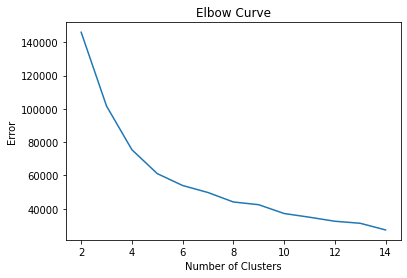

In [ ]:
error=np.zeros(13)
k_components=np.arange(2,15)
for i, k in enumerate(k_components):
  kmeans=KMeans().setK(k).setSeed(1).setFeaturesCol('scaledFeatures')
  clustering_model=kmeans.fit(final_features)
  error[i]=clustering_model.summary.trainingCost
  print("Error with k =",k," is ",error[i])

df_cost = pd.DataFrame(error[0:])
df_cost.columns = ["error"]
df_cost.insert(0, 'cluster', k_components)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.error)
pl.xlabel('Number of Clusters')
pl.ylabel('Error')
pl.title('Elbow Curve')
pl.show()


Silhouette Score with k = 2  is  0.5674941925445168
Silhouette Score with k = 3  is  0.08850777366376476
Silhouette Score with k = 4  is  0.11863399646852495
Silhouette Score with k = 5  is  0.11441366332365989
Silhouette Score with k = 6  is  0.05647208138207552
Silhouette Score with k = 7  is  0.027918387828728245
Silhouette Score with k = 8  is  0.021372857784360582
Silhouette Score with k = 9  is  0.004321394509726348
Silhouette Score with k = 10  is  -0.037625621553040334
Silhouette Score with k = 11  is  -0.06358273189209997
Silhouette Score with k = 12  is  -0.09763840873923134
Silhouette Score with k = 13  is  -0.07077387207336756
Silhouette Score with k = 14  is  -0.10041782141848525


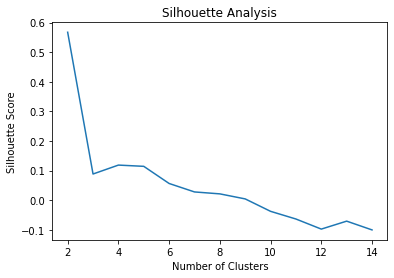

In [ ]:
silhouette_scores=np.zeros(13)
k_components=np.arange(2,15)
for i, k in enumerate(k_components):
    kmeans=KMeans().setK(k).setSeed(1).setFeaturesCol('scaledFeatures')
    clustering_model=kmeans.fit(final_features)
    preds=clustering_model.transform(final_features)
    evaluator=ClusteringEvaluator()
    silhouette=evaluator.evaluate(preds)
    silhouette_scores[i]=silhouette
    print("Silhouette Score with k =",k," is ",silhouette_scores[i])

df_cost = pd.DataFrame(silhouette_scores[0:])
df_cost.columns = ["score"]
df_cost.insert(0, 'cluster', k_components)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.score)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Silhouette Analysis')
pl.show()

## **We can see from the elbow method and sihoulette graph that the best value of k is 4 or 5**

In [ ]:
# Lets fit our final Kmeans model with k=5 based on the elbow method and sihoulette graph
kmeans=KMeans().setK(5).setSeed(1).setFeaturesCol('scaledFeatures')
clustering_model=kmeans.fit(final_features)
preds=clustering_model.transform(final_features)